### Making ionizing flux - density plots using outputs from python and cloudy 
This notebook shows you how to make ionizing flux v density plots of the kind in Matthews et al. 2020 (M20), where we compare outputs from a disc wind model to those from cloudy. The ionizing photon flux $\phi_H$ is related to the ionization parameter $U$ by 
$$\phi_H = U c n_H $$
(see equations in sec 2 of M20). 

The basic procedure here is:
* read line emissivities and so on from cloudy grid, stored in data/cloudy_lines.dat
* read outputs from py_wind; ideally use your own, but I've example outputs in data/
* plot the result

**Prerequisites:**
To create the outputs from py_wind, compile py_wind with the same version of the code you used to run the code, and then run 

    py_wind root < py_wind_cmds.txt
    
where root is your model namethe file py_wind_cmds.txt is a file included in the repository and should generate the right files. 

This code requires ```numpy```, ```matplotlib```, and also uses the routine ```py_read_output```, which means you should add ```$PYTHON/py_progs/``` to your ```$PYTHONPATH``` environment variable.

Text(0, 0.5, '$\\log[\\bar{\\phi}_H~(\\mathrm{cm}^{-2}~\\mathrm{s}^{-1})]$')

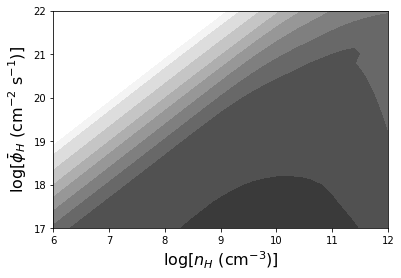

In [58]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from decimal import Decimal
import py_read_output as rd

def get_cloudy_data(fname="data/cloudy_lines.dat"):
    '''
    read cloudy grid data from a file and reshape into 2D arrays stored in dictionary
    '''
    # read in cloudy data 
    data = np.genfromtxt(fname, unpack=True)

    # this is what I used to generate the grid 
    delta = Decimal(0.2)
    cloudy = dict()
    cloudy["log_phi"] = np.arange(17,22+delta,delta)
    cloudy["log_n"] = np.arange(6,12+delta,delta)
    # shape of grid
    shape = (len(cloudy["log_phi"] ),len(cloudy["log_n"]))

    # reshape arrays from file
    cloudy["lum_cont"] = data[2].reshape(shape)
    cloudy["lum_lalpha"] = data[3].reshape(shape)
    cloudy["lum_c4"] = data[4].reshape(shape)
    return cloudy

cloudy = get_cloudy_data()

plt.contourf(cloudy["log_n"], cloudy["log_phi"], cloudy["lum_lalpha"]-cloudy["lum_cont"], levels = np.arange(-4,2,0.5), cmap="binary")
plt.xlabel("$\log[n_H~(\mathrm{cm}^{-3})]$", fontsize=16)
plt.ylabel(r"$\log[\bar{\phi}_H~(\mathrm{cm}^{-2}~\mathrm{s}^{-1})]$", fontsize=16)

In [59]:
def get_py_data(root):
    '''
    Read python outputs from .dat files generated by py_wind
    '''
    py_data = dict()
    keys = ["IP", "ioncH1", "ioncH2", "xi", "lineC4", "vol", "lev2_emiss"]

    for k in keys:
        _, _, var, _=rd.read_pywind("{}.{}.dat".format(root, k), return_inwind=True)
        py_data[k] = var


    py_data["lineC4"][(py_data["lineC4"] == 0)] = 1e-99
    py_data["lev2_emiss"][(py_data["lev2_emiss"] == 0)] = 1e-99
    py_data["nh"] = py_data["ioncH1"] +  py_data["ioncH2"]
    py_data["phi"] = py_data["IP"] * nh * 3e10
    
    return (py_data)

# edit this to use your own file 
f = "data/run79_thmin70_thmax85_rv1e19_f0p01_r1"
py_data = get_py_data(f)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log10


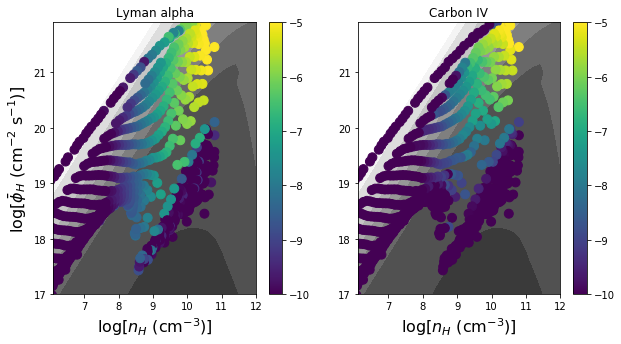

In [54]:
def set_lims():
	plt.xlim(6.1,12)
	plt.ylim(17,21.9)

def make_figure(py_data, cloudy): 
    '''
    Make an ionizing flux density plot when provided with two dictionaries containing 
    data from python and cloudy 
    '''
    
    VMIN = -10
    VMAX = -5
    fig = plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.contourf(cloudy["log_n"], cloudy["log_phi"], cloudy["lum_lalpha"]-cloudy["lum_cont"], levels = np.arange(-4,2,0.5), cmap="binary")
    emiss = py_data["lev2_emiss"] / py_data["vol"]
    plt.scatter(np.log10(py_data["nh"]), np.log10(py_data["phi"]), c=np.log10(emiss), alpha=1, s=80, vmin=VMIN, vmax=VMAX)
    plt.colorbar()
    plt.xlabel("$\log[n_H~(\mathrm{cm}^{-3})]$", fontsize=16)
    plt.ylabel(r"$\log[\bar{\phi}_H~(\mathrm{cm}^{-2}~\mathrm{s}^{-1})]$", fontsize=16)
    plt.title("Lyman alpha")
    set_lims()

    plt.subplot(1,2,2)
    plt.contourf(cloudy["log_n"], cloudy["log_phi"], cloudy["lum_lalpha"]-cloudy["lum_cont"], levels = np.arange(-4,2,0.5), cmap="binary")

    emiss = py_data["lineC4"] / py_data["vol"]
    plt.scatter(np.log10(py_data["nh"]), np.log10(py_data["phi"]), c=np.log10(lc4/vol), alpha=1, s=80, vmin=VMIN, vmax=VMAX)
    plt.colorbar()
    plt.xlabel("$\log[n_H~(\mathrm{cm}^{-3})]$", fontsize=16)
    plt.title("Carbon IV")
    set_lims()
    return (fig)

fig = make_figure(py_data, cloudy)